In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from tkinter import *
from PIL import Image, ImageDraw
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
# Class for the neural network 
class NeuralNetwork:
    def __init__(self, layers, batch_size, learning_rate, iterations):
        self.layers = layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.params = self.init_params()

    def init_params(self):
        params = {}
        for i in range(1, len(self.layers)):
            params[f'W{i}'] = np.random.randn(self.layers[i], self.layers[i - 1]) * np.sqrt(2. / self.layers[i - 1])
            params[f'b{i}'] = np.zeros((self.layers[i], 1))
        return params

    def ReLU(self, Z):
        return np.maximum(Z, 0)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)

    def forward_prop(self, X):
        intermediate_results = {'A0': X}
        A = X
        for i in range(1, len(self.layers) - 1):
            Z = self.params[f'W{i}'] @ A + self.params[f'b{i}']
            A = self.ReLU(Z)
            intermediate_results[f'Z{i}'] = Z
            intermediate_results[f'A{i}'] = A
        Z = self.params[f'W{len(self.layers) - 1}'] @ A + self.params[f'b{len(self.layers) - 1}']
        A = self.softmax(Z)
        intermediate_results[f'Z{len(self.layers) - 1}'] = Z
        intermediate_results[f'A{len(self.layers) - 1}'] = A
        return intermediate_results

    def backward_prop(self, intermediate_results, X, Y):
        gradients = {}
        one_hot_Y = self.one_hot(Y)
        m = X.shape[1]
        A_last = intermediate_results[f'A{len(self.layers) - 1}']
        dZ = A_last - one_hot_Y
        gradients[f'dW{len(self.layers) - 1}'] = 1 / m * dZ @ intermediate_results[f'A{len(self.layers) - 2}'].T
        gradients[f'db{len(self.layers) - 1}'] = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        for i in range(len(self.layers) - 2, 0, -1):
            dZ = (self.params[f'W{i + 1}'].T @ dZ) * self.ReLU_deriv(intermediate_results[f'Z{i}'])
            gradients[f'dW{i}'] = 1 / m * dZ @ intermediate_results[f'A{i - 1}'].T
            gradients[f'db{i}'] = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        return gradients

    def ReLU_deriv(self, Z):
        return Z > 0

    def cross_entropy(self, one_hot_Y, pred_Y):
        m = one_hot_Y.shape[1]
        return -np.sum(one_hot_Y * np.log(pred_Y)) / m

    def one_hot(self, Y):
        one_hot_Y = np.zeros((self.layers[-1], Y.size))
        one_hot_Y[Y, np.arange(Y.size)] = 1
        return one_hot_Y

    def update_params(self, gradients):
        for i in range(1, len(self.layers)):
            self.params[f'W{i}'] -= self.learning_rate * gradients[f'dW{i}']
            self.params[f'b{i}'] -= self.learning_rate * gradients[f'db{i}']

    def fit(self, X, Y):
        for i in range(self.iterations):
            X, Y = shuffle(X.T, Y)
            X = X.T
            batches = [(X[:, k:k + self.batch_size], Y[k:k + self.batch_size]) for k in
                       range(0, X.shape[1], self.batch_size)]
            for batch_X, batch_Y in batches:
                intermediate_results = self.forward_prop(batch_X)
                gradients = self.backward_prop(intermediate_results, batch_X, batch_Y)
                self.update_params(gradients)

    def predict(self, X):
        intermediate_results = self.forward_prop(X)
        A_last = intermediate_results[f'A{len(self.layers) - 1}']
        return np.argmax(A_last, axis=0)

    def score(self, X, Y):
        predictions = self.predict(X)
        return np.mean(predictions == Y)


In [3]:

# Load datasets
train_data = pd.read_csv('MNIST-train.csv')
test_data = pd.read_csv('MNIST-test.csv')

# Shuffle and split the training data
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

X_train_full = train_data.iloc[:, :-1].values  # Features (all columns except the last one)
y_train_full = train_data.iloc[:, -1].values  # Labels (last column)

# Split into training (90%) and validation (10%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = test_data.iloc[:, :-1].values / 255.0
y_test = test_data.iloc[:, -1].values

# Transpose to match the format
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T

nn = NeuralNetwork(layers=[784, 256, 64, 10], batch_size=32, learning_rate=0.1, iterations=10)

nn.fit(X_train, y_train)

# Validate the model
val_accuracy = nn.score(X_val, y_val)
print(f"Validation accuracy: {val_accuracy}")

# Test the model
test_accuracy = nn.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Validation accuracy: 0.9788333333333333
Test accuracy: 0.98


In [4]:
def prepare(filepath):
    """
    Prepares the image for prediction by reading it, converting to grayscale, resizing to 28x28, and normalizing
    
    :param filepath: The path to the image file.
    :return: normalized 28x28 numpy array representing the image
    """
    size = 28
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (size, size))
    return new_array.reshape(size, size) / 255.0


def save():
    """
    Saves the drawn image, processes it for prediction, displays it, and prints the prediction to the scrreen
    """
    filename = "image.jpg"
    image1.save(filename)
    root.destroy()
    processed_image = prepare("image.jpg")
    plt.imshow(processed_image, cmap=plt.cm.binary, interpolation='nearest')
    plt.show()
    processed_image = processed_image.reshape(784, 1)
    prediction = nn.predict(processed_image)
    print(f"Prediction: {prediction[0]}")


def paint(event):
    """
    This function lets you draw on the canvas by creating a grey rectangle where you drag the mouse 
    
    :param event: The event object with details about the mouse event.
    """
    x1, y1 = (event.x - 3), (event.y - 3)
    x2, y2 = (event.x + 3), (event.y + 3)
    cv.create_rectangle(x1, y1, x2, y2, fill="grey")
    draw.line([x1, y1, x2, y2], fill="grey", width=18)


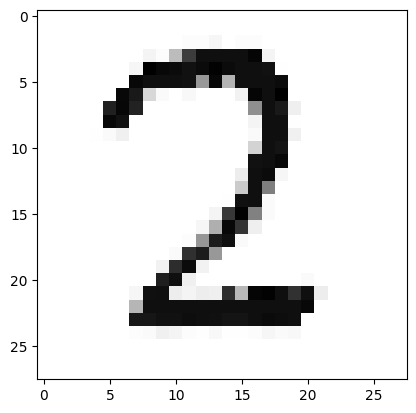

Prediction: 2


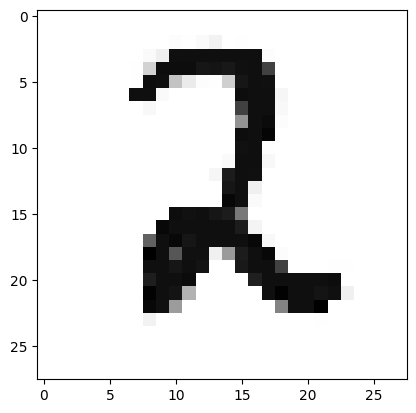

Prediction: 2


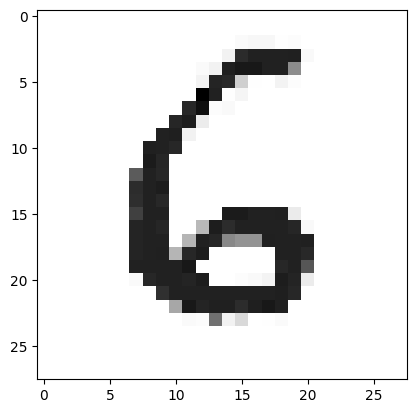

Prediction: 6


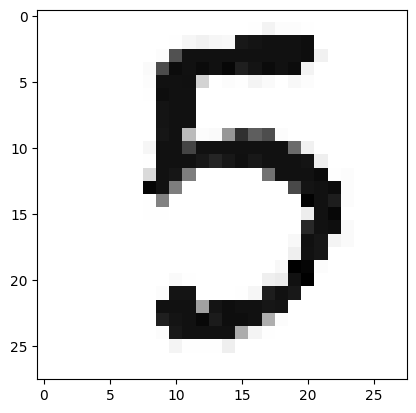

Prediction: 5


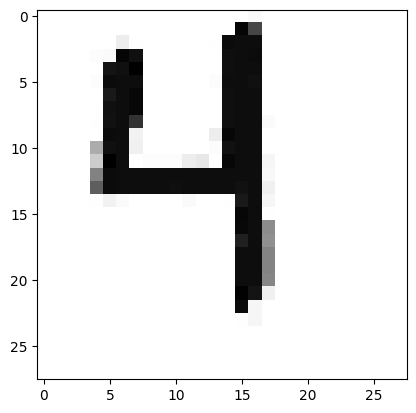

Prediction: 4


KeyboardInterrupt: 

In [5]:
for i in range(11):
    width = 200
    height = 200
    black = (0, 0, 0)
    white = (255, 255, 255)
    root = Tk()
    cv = Canvas(root, width=width, height=height, bg='white')
    cv.pack()
    image1 = Image.new("RGB", (width, height), black)
    draw = ImageDraw.Draw(image1)
    cv.pack(expand=YES, fill=BOTH)
    cv.bind("<B1-Motion>", paint)
    button = Button(text="save", command=save)
    button.pack()
    root.mainloop()